# Lab Assignment 3

**Submission deadline:**
* **Regular problems: Sunday 23:59 January 9th 2022**


**Points: 2+9+3+2+2 = 18 points**


In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [ ]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a column of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variable, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the dataframe's `apply` function to compute the entropy of all columns.

In [ ]:
def entropy(series):
    values_num = series.count()
    values = series.value_counts()
    values = values.apply(lambda x: -x/values_num*np.log(x/values_num) / np.log(2))
    return values.sum()#np.around(values.sum(), decimals = 3)
mushroom_df.apply(entropy)

target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.822922
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                   0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighing them by how frequently the value $x$ occured.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [ ]:
mushroom_df['target'].value_counts()

e    4208
p    3916
Name: target, dtype: int64

In [ ]:
def cond_entropy(X, Y):
    """Compute the conditional H(X|Y) in dataframe df
    Args:
        X: series whose entropy we wish to compute
        Y: series on which we condition
    """
    values_num = Y.count()
    values_y = Y.value_counts()
    merged_data = pd.concat([X.rename('col1'),Y.rename('col2')], axis=1)
    g = merged_data.groupby('col2')
    res = 0
    for i, v_y in enumerate(values_y):
        py = v_y / values_num
        y = values_y.index[i]
        px = entropy(merged_data['col1'][g.groups[y]])
        res += py*px
        #z = z
    return res#np.around(res, decimals = 3)
    
    
for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {cond_entropy(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 0.0
cap-shape                :	 0.95
cap-surface              :	 0.97
cap-color                :	 0.963
bruises?                 :	 0.807
odor                     :	 0.093
gill-attachment          :	 0.985
gill-spacing             :	 0.898
gill-size                :	 0.769
gill-color               :	 0.582
stalk-shape              :	 0.992
stalk-root               :	 0.864
stalk-surface-above-ring :	 0.714
stalk-surface-below-ring :	 0.727
stalk-color-above-ring   :	 0.745
stalk-color-below-ring   :	 0.758
veil-type                :	 0.999
veil-color               :	 0.975
ring-number              :	 0.961
ring-type                :	 0.681
spore-print-color        :	 0.518
population               :	 0.797
habitat                  :	 0.842


In [ ]:
def mutual_information(X, Y):
    #TODO implement mutual information using the formula H(X,Y) - E(X|Y) - E(Y|X)
    return entropy(Y) - cond_entropy(Y,X)
    


for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {mutual_information(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 0.999
cap-shape                :	 0.049
cap-surface              :	 0.029
cap-color                :	 0.036
bruises?                 :	 0.192
odor                     :	 0.906
gill-attachment          :	 0.014
gill-spacing             :	 0.101
gill-size                :	 0.23
gill-color               :	 0.417
stalk-shape              :	 0.008
stalk-root               :	 0.135
stalk-surface-above-ring :	 0.285
stalk-surface-below-ring :	 0.272
stalk-color-above-ring   :	 0.254
stalk-color-below-ring   :	 0.241
veil-type                :	 0.0
veil-color               :	 0.024
ring-number              :	 0.038
ring-type                :	 0.318
spore-print-color        :	 0.481
population               :	 0.202
habitat                  :	 0.157


We can see from the above listing that the features that share the most information with the target are "odor" (0.906), "spore-print-color" (0.481), and "gill-color" (0.417). Let us remember that once we will have a final decision tree.

## Correlation vs mutual information

Here's an example for why we care about mutual information in the first place.
There are very natural cases when correlation of two random variables is very low (in the example it's actually a perfect 0), even though they may be incredibly dependent. It turns out that zero correlation only tells us whether two random variables do not have any linear relationship between them.

,x,|x|
-1.0,-1.0,1.0
0.0,0.0,0.0
1.0,1.0,1.0


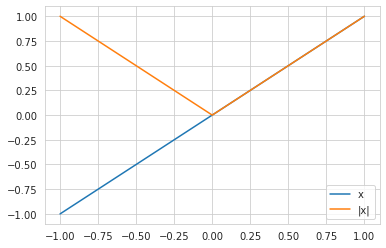

In [ ]:
df = pd.DataFrame(index=np.linspace(-1,1,3))
df['x'] = df.index
df['|x|'] = np.abs(df['x'])
df.plot()
df

Correlation (covariance) of random variables X and |X| is 0.

In [ ]:
df['x'].dot(df['|x|'])

0.0

However, they are very dependent, since knowing $x$ immediately tells us what the value of $|x|$ is. 
And this actually can be seen by looking at the conditional entropy of $H(|X|\ | X)$ the variables.

In [ ]:
cond_entropy(df["|x|"], df["x"]).round(decimals=9)

0.0

The above result clearly implements our intuition --- once we know $x$, there's no uncertainty left about $|x|$.

What about the reverse conditioning?

In [ ]:
entropy(df['x']), np.log2(3)

(1.585, 1.584962500721156)

In [ ]:
entropy(df['|x|']), (1/3)*np.log2(3) + (2/3)*np.log2(3/2)

(0.918, 0.9182958340544893)

In [ ]:
cond_entropy(df["x"], df["|x|"]).round(decimals=3)

0.667

This result has a natural intepretation: 1 cases out of 3 $|x|$ is zero in which case we know what $x$ is, so in this case the entropy is $0$, cause there's no uncertainty left. 2 cases out of 3 we have $|x| = 1$, in which case the uncertainty which remains is the probability distribution of the sign. The probability distribution of the sign is just $P(\mbox{sign is }+) = 1/2 = P(\mbox{sign is }-)$ and its entropy is $-\left(\frac{1}{2}\log(1/2) + \frac{1}{2}\log(1/2)\right)=1$. Hence the total conditional entropy is $\frac{2}{3}$.

At the end let us look at the actual mutual information based on what we already saw.

In [ ]:
mutual_information(df['x'], df['|x|'])

0.918

Makes sense, right?

### Implement infogain ratio [1p]
Add an ID column that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



In [ ]:
mushroom_df.insert(0, 'id', np.arange(mushroom_df.shape[0]))
print(f"H(target|ID):\t {cond_entropy(mushroom_df['target'], mushroom_df['id']).round(decimals=3)}")
print(f"I(target,ID):\t {mutual_information(mushroom_df['target'], mushroom_df['id']).round(decimals=3)}")

H(target|ID):	 0.0
I(target,ID):	 0.999


In [ ]:
for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t IG {mutual_information(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}\t IGR {mutual_information(mushroom_df['target'], mushroom_df[cname])/ entropy(mushroom_df[cname]):.3f}")

id                       :	 IG 0.999	 IGR 0.077
target                   :	 IG 0.999	 IGR 1.000
cap-shape                :	 IG 0.049	 IGR 0.030
cap-surface              :	 IG 0.028	 IGR 0.018
cap-color                :	 IG 0.036	 IGR 0.014
bruises?                 :	 IG 0.192	 IGR 0.196
odor                     :	 IG 0.905	 IGR 0.390
gill-attachment          :	 IG 0.014	 IGR 0.081
gill-spacing             :	 IG 0.101	 IGR 0.158
gill-size                :	 IG 0.23	 IGR 0.258
gill-color               :	 IG 0.416	 IGR 0.137
stalk-shape              :	 IG 0.008	 IGR 0.008
stalk-root               :	 IG 0.135	 IGR 0.074
stalk-surface-above-ring :	 IG 0.284	 IGR 0.233
stalk-surface-below-ring :	 IG 0.272	 IGR 0.194
stalk-color-above-ring   :	 IG 0.254	 IGR 0.131
stalk-color-below-ring   :	 IG 0.241	 IGR 0.122
veil-type                :	 IG 0.0	 IGR nan
veil-color               :	 IG 0.024	 IGR 0.122
ring-number              :	 IG 0.039	 IGR 0.093
ring-type                :	 IG 0.318	 IGR 0.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


H(target|ID) 0.0
I(target,ID) 0.999
Infogains:
index                    :	 IG 0.999		IGR 0.077
target                   :	 IG 0.999		IGR 1.0
cap-shape                :	 IG 0.049		IGR 0.03
cap-surface              :	 IG 0.029		IGR 0.018
cap-color                :	 IG 0.036		IGR 0.014
bruises?                 :	 IG 0.192		IGR 0.196
odor                     :	 IG 0.906		IGR 0.391
gill-attachment          :	 IG 0.014		IGR 0.082
gill-spacing             :	 IG 0.101		IGR 0.158
gill-size                :	 IG 0.23		IGR 0.258
gill-color               :	 IG 0.417		IGR 0.138
stalk-shape              :	 IG 0.008		IGR 0.008
stalk-root               :	 IG 0.135		IGR 0.074
stalk-surface-above-ring :	 IG 0.285		IGR 0.233
stalk-surface-below-ring :	 IG 0.272		IGR 0.194
stalk-color-above-ring   :	 IG 0.254		IGR 0.131
stalk-color-below-ring   :	 IG 0.241		IGR 0.122
veil-type                :	 IG 0.0		IGR nan
veil-color               :	 IG 0.024		IGR 0.121
ring-number              :	 IG 0.038		IGR 0.091
r

<ipython-input-16-2ddd216e9e8e>:11: RuntimeWarning: invalid value encountered in double_scalars
  info_gain_ratio = info_gain / entropy(m2[cname])


# Problem 2: Decision Tree Implementation [9p]

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine learning toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values for a two-class set with given class probabilities.

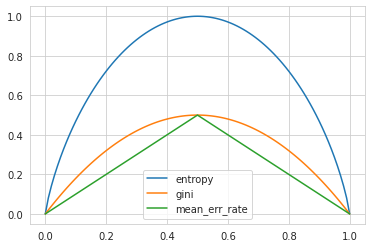

In [ ]:
def entropy(counts):
    s = counts.sum()
    p = counts / s
    return - np.sum(p[p > 0] * np.log2(p[p > 0]))

def gini(counts):
    s = counts.sum()
    p = counts / s
    return 1 - np.sum(p ** 2)

def mean_err_rate(counts):
    s = counts.sum()
    p = counts / s
    return 1 - p.max()

fractions = np.linspace(0, 1, 101)
for func in [entropy, gini, mean_err_rate]:
    err_rates = [func(np.array([f, 1.0-f])) for f in fractions]
    plt.plot(fractions, err_rates, label = func.__name__)
plt.legend()

# Make a plot of the purity functions


## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [ ]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [ ]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        if pd.isnull(x[self.attr]) or x[self.attr] not in self.subtrees:
            children = [(s.info['num_samples'], s) for s in self.subtrees.values()]
            return max(children, key = lambda ag: ag[0])[1]
        #print(x[self.attr], x, self.attr)
        return self.subtrees[x[self.attr]] 

    def iter_subtrees(self):
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")

In [ ]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    mean_child_purity = 0
    for group_name, group_df in df.groupby(attr):
        mean_child_purity += purity_fun(group_df['target'].value_counts())
    mean_child_purity /= len(df[attr].unique())
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [ ]:
def get_split(df, criterion="infogain", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # TermCrit1: Node is pure
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    possible_splits = [c for c in df.columns if c != 'target' and (len(df[c].unique()) > 1)]
    assert "target" not in possible_splits
    #    Terminate early if none are possivle
    if not possible_splits:
        return None

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    if nattrs is not None:
        possible_splits = np.random.choice(possible_splits, nattrs)
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity

        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [ ]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4
        #assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
        }

        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            return self.split(sample).get_target_distribution(sample)
            # TODO: descend into subtrees and return the leaf target distribution
            
    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        return self.get_target_distribution(sample).idxmax()

    def proximity(self, sample):
        return self.get_target_distribution(sample)
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

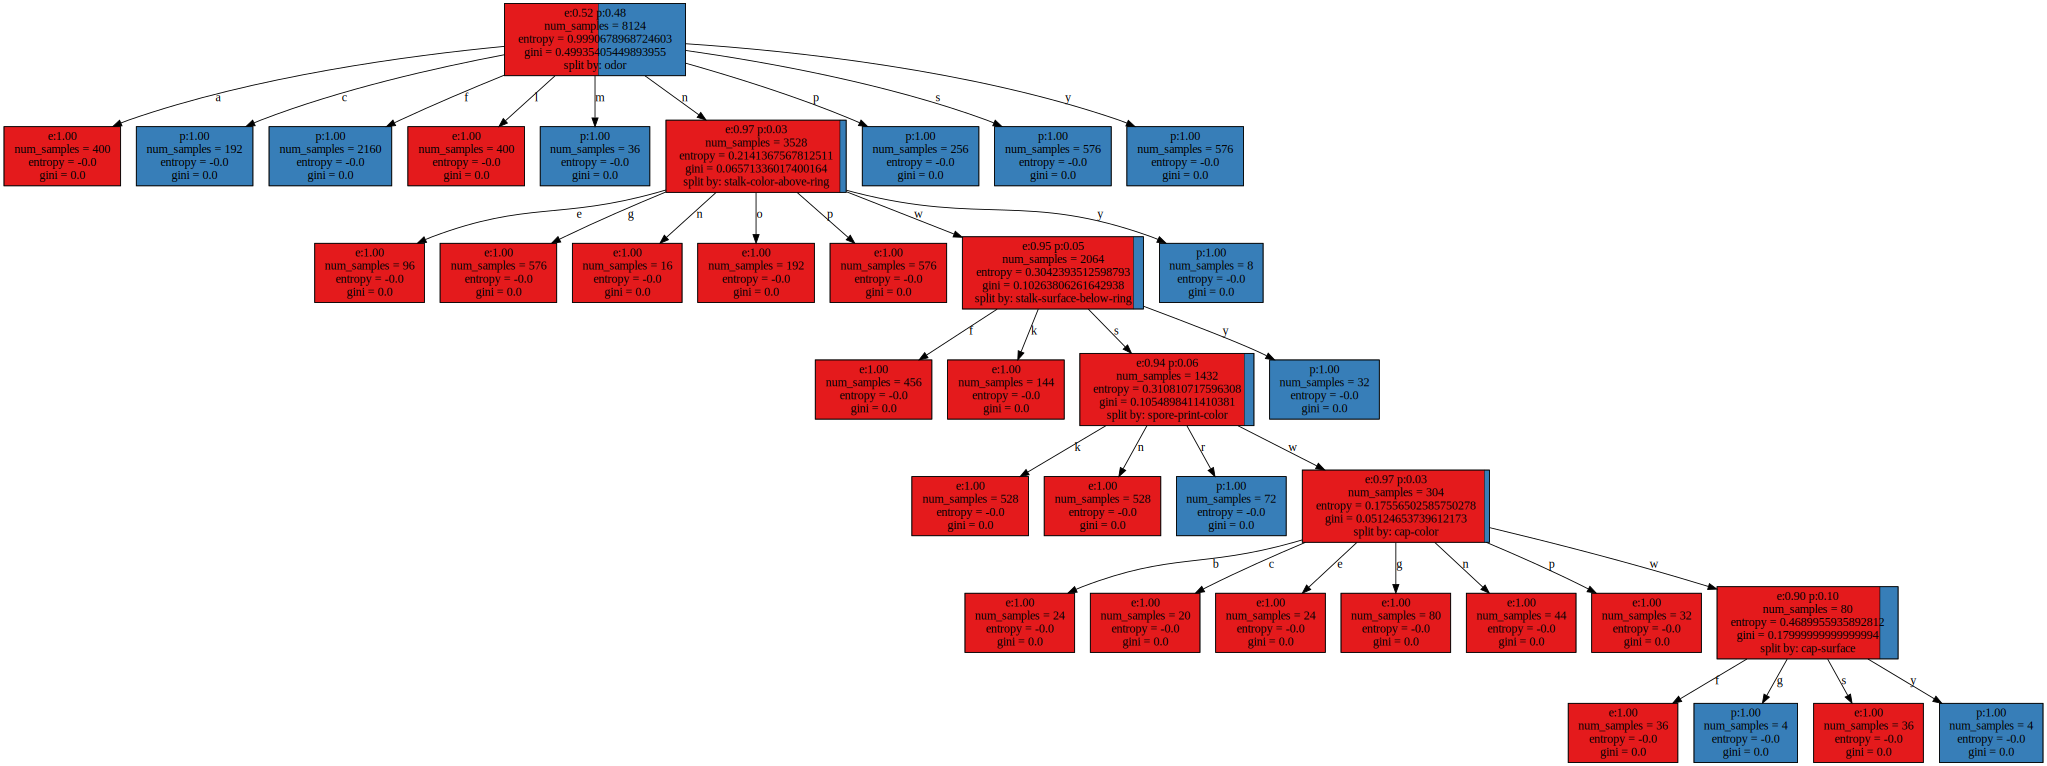

In [ ]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.

# Note: for this code to work you must fix the todos in the previous sections

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

**Answer the questions below:**
1. How many samples are classified correctly by a tree with only one split?
2. Is the tree different when different purity functions are used?


## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [ ]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs),
        )

    def __call__(self, x):
        # return the sobtree for the data sample `x`
        if x[self.attr] <= self.th:
          return self.subtrees[0]
        else:
          return self.subtrees[1]

    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numrical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, "target"]].sort_values(attr)
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0

        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)
        split = NumericalSplit(attr, split_threshold)
        # the loop should return the best possible split.

        # TODO: update left_counts and right_counts
        right_counts[row_target] -= 1
        left_counts[row_target] += 1


        # The split is possible if attribute_value != next_attribute_value
        if attribute_value == next_attribute_value:
            continue
        purity_gain = parent_purity - ((row_i + 1)*purity_fun(left_counts) + (N - row_i - 1)*purity_fun(right_counts))/N
        if purity_gain > best_purity_gain:
            best_split, best_purity_gain = split, purity_gain
        # TODO: now consider the split at split_threshold and save it if it the best one
        #purity_gain = 
    return best_split, best_purity_gain

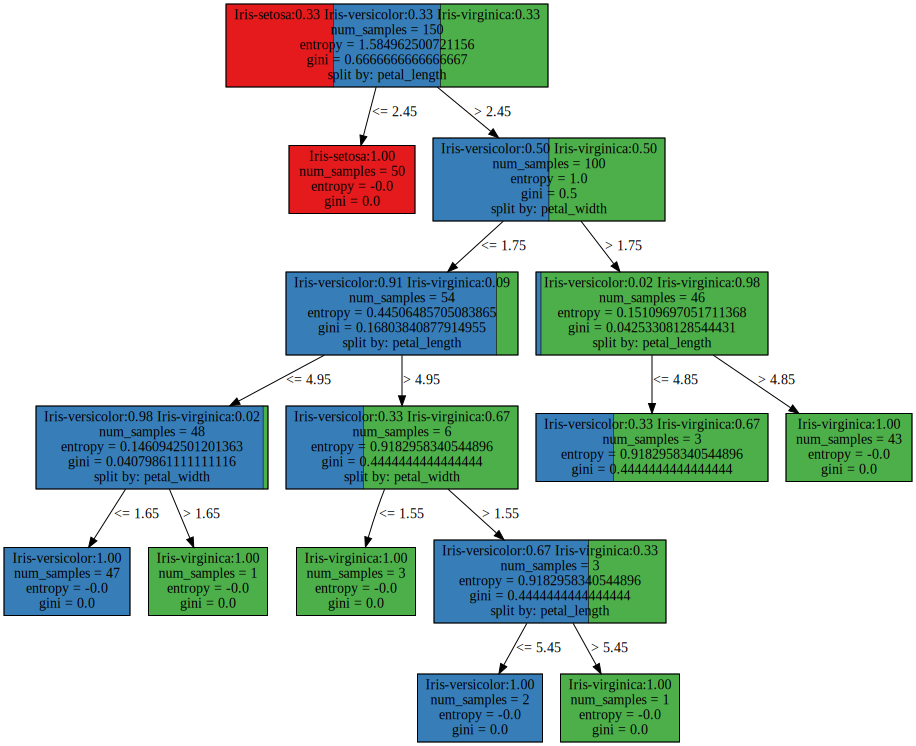

In [ ]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]

iristree = Tree(iris2d, criterion='infogain')
iristree.draw()


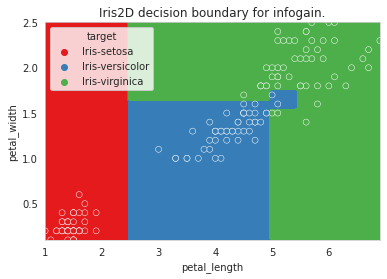

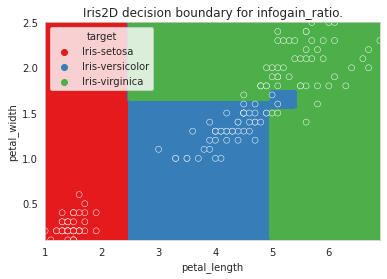

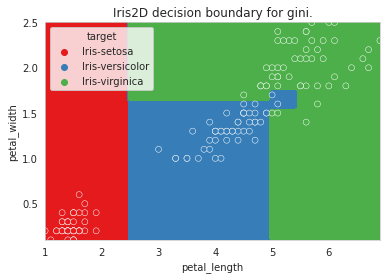

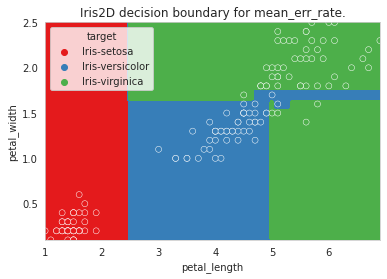

In [ ]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## Decision Tree Task 4: Handling missing data [2p]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the sample misses attribute's value, we put a weighted copy of the sample down each subtree, with the weight equal to the probability that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

In [ ]:
for i in np.arange(0,1,0.1):
    mdf = mushroom_df.copy()
    X = mushroom_df.sample(n=500)
    Y = X['target']

#create missing data
    for col in mdf.columns: 
        if col != 'target':
            mdf.loc[mdf.sample(frac=i).index, col] = np.nan
    mdf_tree = Tree(mdf)

    for col in X.columns:
        if col != 'target':
            X.loc[X.sample(frac=i).index, col] = np.nan

    y_preds = [mdf_tree.classify(x) for _ ,x in X.iterrows()]
    print(f'missing data ratio :{i:.3f} err_rate: {np.sum(y_preds != Y)/len(Y)}')

missing data ratio :0.000 err_rate: 0.0
missing data ratio :0.100 err_rate: 0.048
missing data ratio :0.200 err_rate: 0.094
missing data ratio :0.300 err_rate: 0.162
missing data ratio :0.400 err_rate: 0.218
missing data ratio :0.500 err_rate: 0.246
missing data ratio :0.600 err_rate: 0.316
missing data ratio :0.700 err_rate: 0.34
missing data ratio :0.800 err_rate: 0.386
missing data ratio :0.900 err_rate: 0.394


## Decision Tree Task 5: Pruning [4p]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning [2p]
Build a tree using all the data. Then split the training set into 10 cross-validation subsets. Then in a loop over the testing cross-validation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning [2p]
Build the decision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.
Remember the homework task on how Reddit sorts comments? The way to do it is to score by lower confidence intervals, approximation of which is calculated using the so called Wilson score https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval. Here you need to use the upper interval, but you can still use the Wilson score.


As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

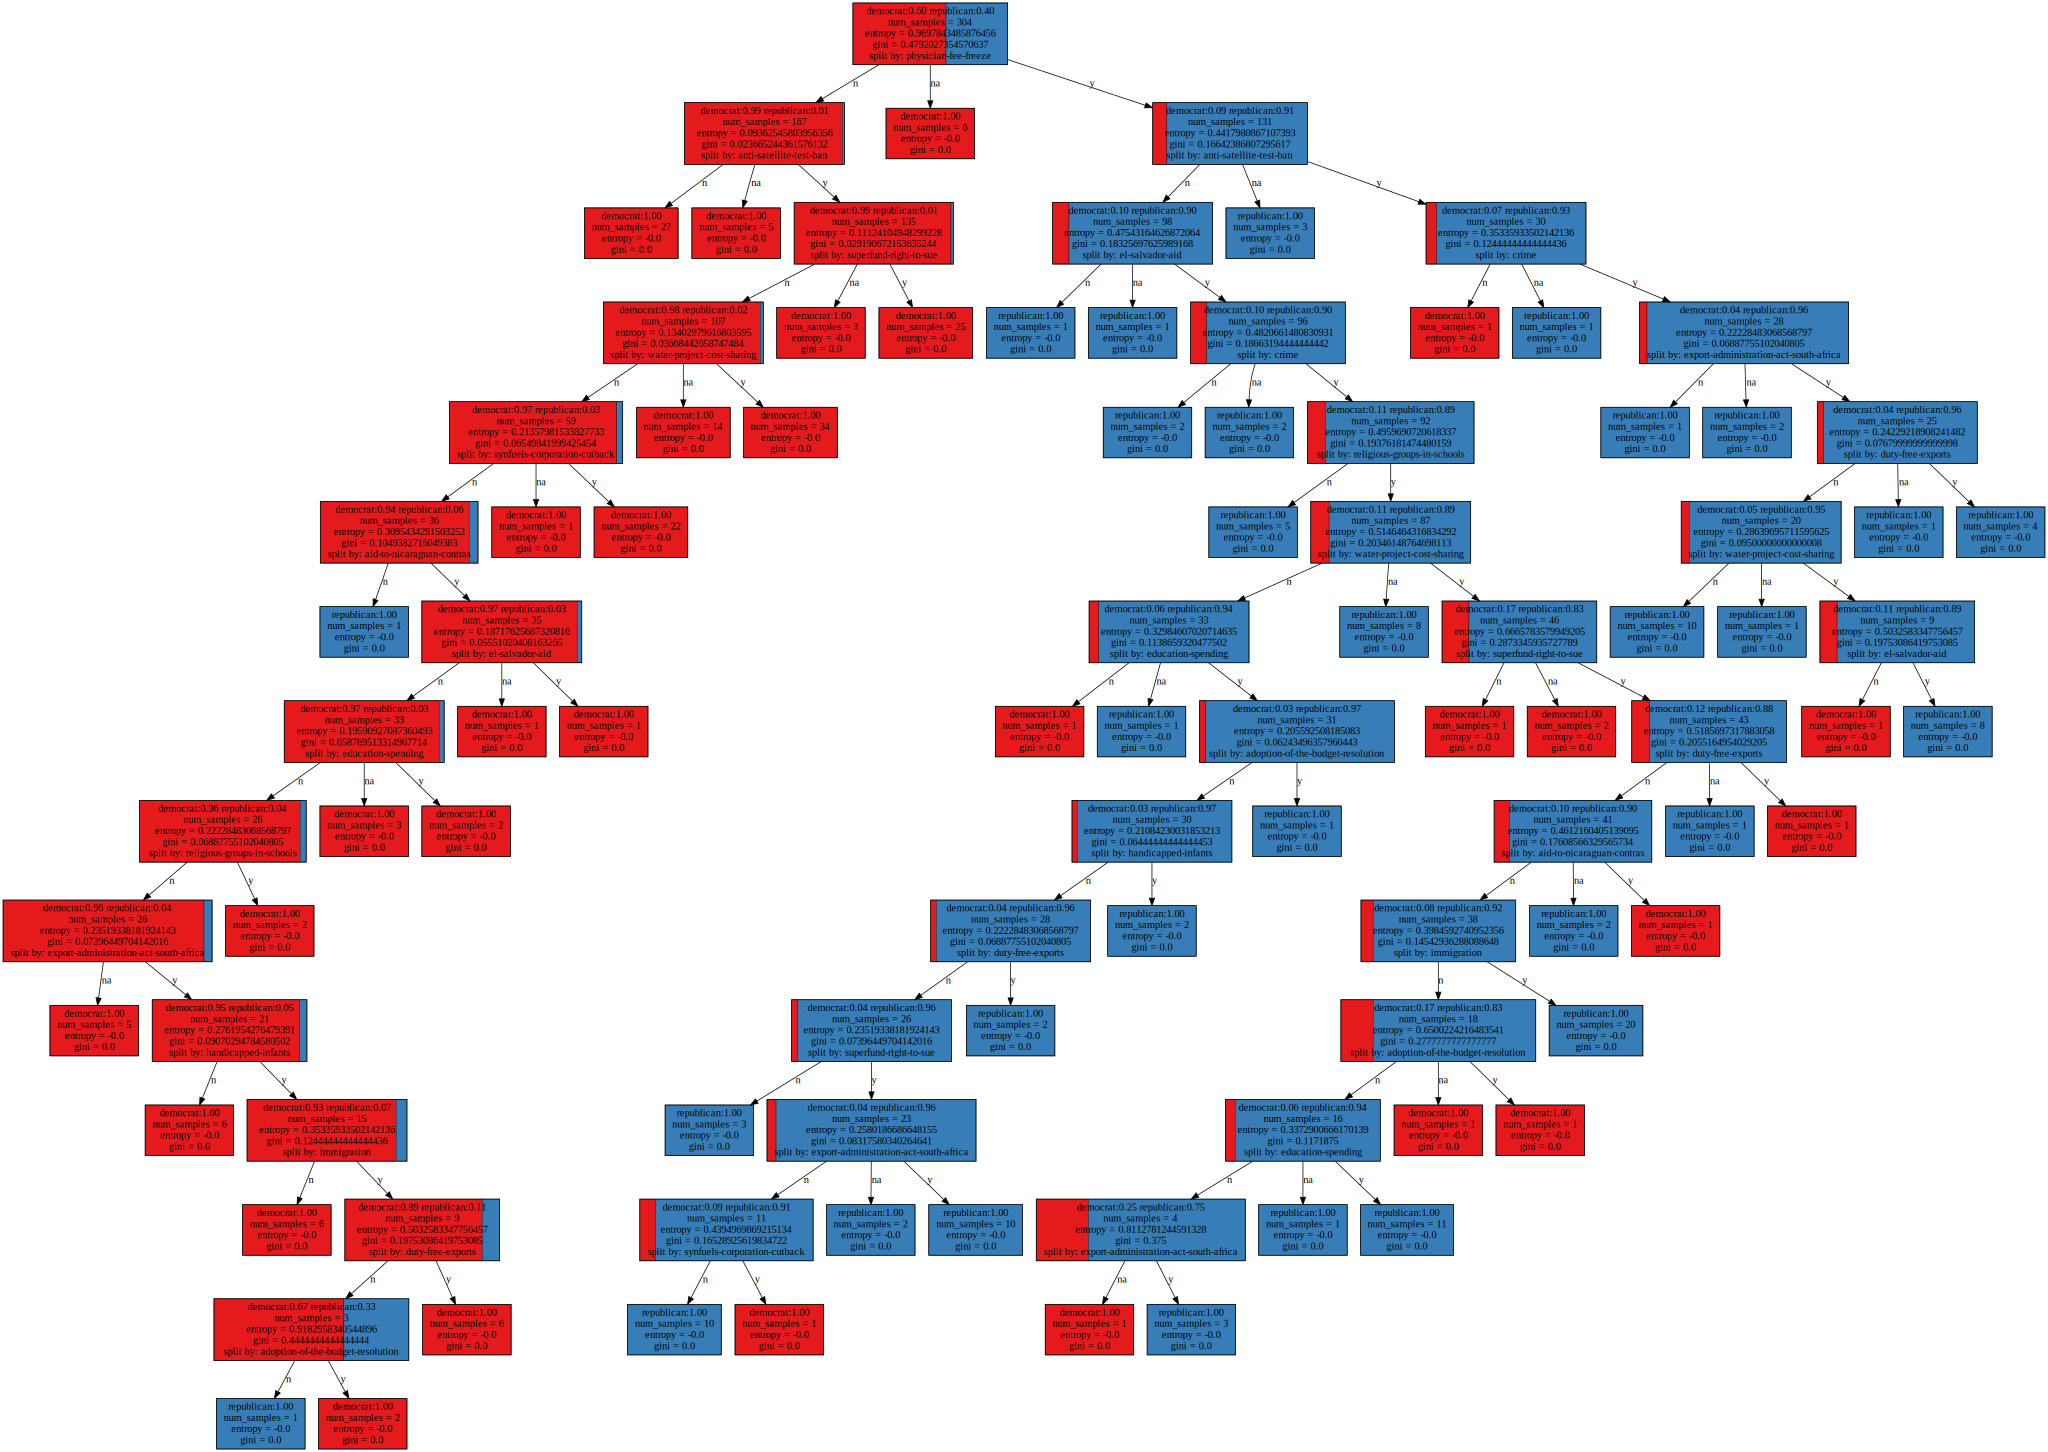

In [ ]:
vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3)
vote_tree = Tree(vote_train_df, criterion='infogain')
vote_tree.draw()


In [ ]:
# TODO: implement a pruning method of your choice
Y = vote_test_df['target']
y_preds = [vote_tree.classify(x) for _ ,x in vote_test_df.iterrows()]
print('Unpruned err_rate: {}'.format(np.sum(y_preds != Y)/len(Y)))

Unpruned err_rate: 0.05343511450381679


Unpruned err_rate: 0.06870229007633588


Unpruned err rate: 0.04580152671755722
Pruned err rate: 0.05343511450381677


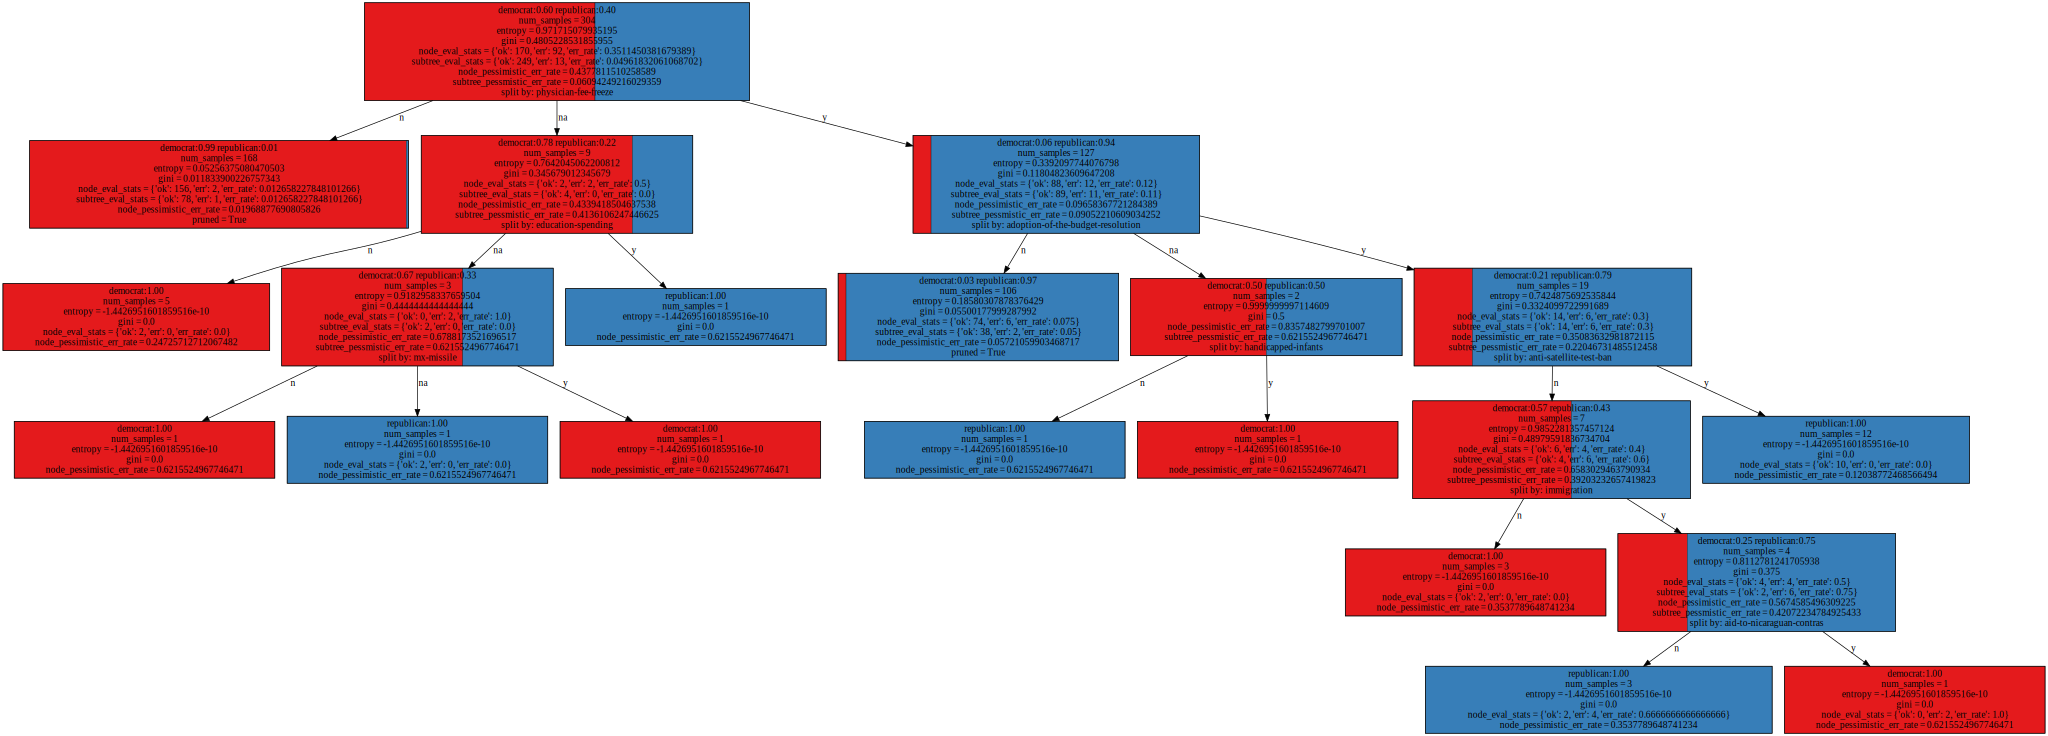

In [ ]:
# TODO: implement a pruning method of your choice



# Problem 3: Random Forest [3p]

We will use the German credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next, train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data splitting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from `sklearn` (see below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(german_df, test_size=0.3)
train_df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,target
523,A14,24,A32,A41,3488,A62,A74,3,A92,A101,4,A123,23,A143,A152,1,A173,1,A191,A201,1
338,A11,24,A32,A42,4169,A61,A73,4,A93,A101,4,A122,28,A143,A152,1,A173,1,A191,A201,1
414,A11,24,A32,A40,1381,A65,A73,4,A92,A101,2,A122,35,A143,A152,1,A173,1,A191,A201,2
379,A14,6,A34,A40,362,A62,A73,4,A92,A101,4,A123,52,A143,A152,2,A172,1,A191,A201,1
437,A14,24,A34,A40,1287,A64,A75,4,A92,A101,4,A121,37,A143,A152,2,A173,1,A192,A201,1


In [ ]:
g_tree = Tree(train_df, criterion='infogain')
g_tree.draw()
Y = test_df['target']
y_preds = [g_tree.classify(x) for _ ,x in test_df.iterrows()]
print('Unpruned err_rate: {}'.format(np.sum(y_preds != Y)/len(Y)))

Unpruned err_rate: 0.3433333333333333


In [ ]:
g_tree.draw()

In [ ]:
class RandomForest():
    def __init__(self, nattrs, trees_num, train_df, test_df, verbose = True):
        self.nattrs = nattrs
        self.train_df = train_df
        self.test_df = test_df
        self.trees_num = trees_num
        self.trees = []
        self.tree_errs = 0
        self.verbose = verbose
        self.create_forest()

    def create_forest(self):
        for t in range(self.trees_num):
            train_folds, test_folds = self.get_folds()
            tree = Tree(train_folds, criterion = 'infogain', nattrs=self.nattrs)
            self.trees.append(tree)
            rf_err_rate = self.get_rf_err(self.train_df, self.test_df)
            err_rate = self.get_tree_err(self.train_df, self.test_df, tree)
            oob_err_rate = self.get_tree_err(train_folds, test_folds, tree)
            self.tree_errs += err_rate
            if self.verbose:
                print(f'Tree {t}: RF Err rate {rf_err_rate:.3f}\t Tree Err rate {err_rate:.3f}\t Tree OOB err rate {oob_err_rate:.3f}')
        oob_rf_err_rate = self.get_rf_err(train_folds, test_folds)
        rf_err_rate = self.get_rf_err(self.train_df, self.test_df)
        print(f'Final Forest OOB Err rate {oob_rf_err_rate}')
        print(f'Final Forest Test Err rate {rf_err_rate}')
        print(f'Mean tree err rate: {self.tree_errs / t}')
        trees_agreed = self.get_trees_agreed(self.test_df)
        print(f'Mean tree aggreement: {trees_agreed}')

    def get_trees_agreed(self, test):
        res = 0
        for i, t1 in enumerate(self.trees):
            for t2 in self.trees[i + 1:]:
                same = 0
                for _,x in test.iterrows():
                    if t1.classify(x) == t2.classify(x):
                        same += 1
                same /= test.shape[0]
                res += same
        
        return res / (len(self.trees) * (len(self.trees) + 1) / 2)
        for _,x in test.iterrows():
            ans = []
            for t in self.trees:
                ans.append(t.classify(x))
            if np.unique(ans).shape[0] == 1:
                res += 1
        return res / test.shape[0]

    def get_rf_err(self, train, test):
        Y = test['target']
        y_preds = [self.classify(x) for _ ,x in test.iterrows()]
        return np.sum(y_preds != Y) / len(Y)

    def get_tree_err(self, train, test, tree):
        Y = test['target']
        y_preds = [tree.classify(x) for _ ,x in test.iterrows()]
        return np.sum(y_preds != Y) / len(Y)

    def classify(self, x):
        ans = []
        for t in self.trees:
            ans.append(t.classify(x))
        return sstats.mode(ans)[0][0]
    
    def get_folds(self):
        train_idx = np.random.choice(train_df.shape[0], train_df.shape[0])
        test_idx = np.delete(np.arange(train_df.shape[0]), train_idx)
        #print(train_df.iloc[train_idx])
        return train_df.iloc[train_idx], train_df.iloc[test_idx]

    def get_prox_measure(self, x1, x2):
        res = 0
        for t in self.trees:
            if t.split(x1) == t.split(x2):
            #if t.proximity(x1) == t.proximity(x2):
                res += 1
        return res / self.trees_num 

In [ ]:
for nattrs in [1,2,3,10]:
    RandomForest(nattrs, 25, train_df, test_df)

Tree 0: RF Err rate 0.360	 Tree Err rate 0.360	 Tree OOB err rate 0.396
Tree 1: RF Err rate 0.287	 Tree Err rate 0.390	 Tree OOB err rate 0.356
Tree 2: RF Err rate 0.327	 Tree Err rate 0.337	 Tree OOB err rate 0.398
Tree 3: RF Err rate 0.277	 Tree Err rate 0.333	 Tree OOB err rate 0.373
Tree 4: RF Err rate 0.270	 Tree Err rate 0.280	 Tree OOB err rate 0.341
Tree 5: RF Err rate 0.250	 Tree Err rate 0.353	 Tree OOB err rate 0.362
Tree 6: RF Err rate 0.247	 Tree Err rate 0.370	 Tree OOB err rate 0.377
Tree 7: RF Err rate 0.237	 Tree Err rate 0.377	 Tree OOB err rate 0.340
Tree 8: RF Err rate 0.253	 Tree Err rate 0.323	 Tree OOB err rate 0.392
Tree 9: RF Err rate 0.233	 Tree Err rate 0.343	 Tree OOB err rate 0.366
Tree 10: RF Err rate 0.233	 Tree Err rate 0.357	 Tree OOB err rate 0.378
Tree 11: RF Err rate 0.257	 Tree Err rate 0.423	 Tree OOB err rate 0.393
Tree 12: RF Err rate 0.253	 Tree Err rate 0.370	 Tree OOB err rate 0.394
Tree 13: RF Err rate 0.240	 Tree Err rate 0.360	 Tree OOB err




nattr: 1


<ipython-input-30-2bce2c2b2fbe>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones(len(german_train_df), dtype=np.bool)


Tree 0: RF Err rate 0.353    Tree Err rate 0.353 Tree OOB err rate 0.354
Tree 1: RF Err rate 0.287    Tree Err rate 0.300 Tree OOB err rate 0.438
Tree 2: RF Err rate 0.250    Tree Err rate 0.343 Tree OOB err rate 0.384
Tree 3: RF Err rate 0.253    Tree Err rate 0.380 Tree OOB err rate 0.410
Tree 4: RF Err rate 0.260    Tree Err rate 0.417 Tree OOB err rate 0.364
Tree 5: RF Err rate 0.260    Tree Err rate 0.380 Tree OOB err rate 0.365
Tree 6: RF Err rate 0.273    Tree Err rate 0.370 Tree OOB err rate 0.361
Tree 7: RF Err rate 0.280    Tree Err rate 0.390 Tree OOB err rate 0.324
Tree 8: RF Err rate 0.260    Tree Err rate 0.380 Tree OOB err rate 0.332
Tree 9: RF Err rate 0.257    Tree Err rate 0.307 Tree OOB err rate 0.326
Tree 10: RF Err rate 0.250    Tree Err rate 0.343 Tree OOB err rate 0.377
Tree 11: RF Err rate 0.257    Tree Err rate 0.387 Tree OOB err rate 0.401
Tree 12: RF Err rate 0.253    Tree Err rate 0.337 Tree OOB err rate 0.385
Tree 13: RF Err rate 0.247    Tree Err rate 0.31

# Problem 4: Implement Variable importance using Random Forests [2p]

Implement the two measures of variable importance in a Random Forest:
1. Total purity increase for all splits using this variable [1p]
2. Forest performance decrease on replacing an attribute with random data. [1p]

Then analyze the variable importance on some datasets (e.g. mushroom and German credit).

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(german_df, test_size=0.3)

In [ ]:
RF = RandomForest(2, 25, train_df, test_df)

Tree 0: RF Err rate 0.111	 Tree Err rate 0.111	 Tree OOB err rate 0.077
Tree 1: RF Err rate 0.129	 Tree Err rate 0.111	 Tree OOB err rate 0.099
Tree 2: RF Err rate 0.099	 Tree Err rate 0.123	 Tree OOB err rate 0.137
Tree 3: RF Err rate 0.111	 Tree Err rate 0.123	 Tree OOB err rate 0.156
Tree 4: RF Err rate 0.088	 Tree Err rate 0.099	 Tree OOB err rate 0.081
Tree 5: RF Err rate 0.076	 Tree Err rate 0.094	 Tree OOB err rate 0.066
Tree 6: RF Err rate 0.070	 Tree Err rate 0.088	 Tree OOB err rate 0.046
Tree 7: RF Err rate 0.076	 Tree Err rate 0.117	 Tree OOB err rate 0.073
Tree 8: RF Err rate 0.058	 Tree Err rate 0.164	 Tree OOB err rate 0.090
Tree 9: RF Err rate 0.058	 Tree Err rate 0.094	 Tree OOB err rate 0.085
Tree 10: RF Err rate 0.058	 Tree Err rate 0.094	 Tree OOB err rate 0.103
Tree 11: RF Err rate 0.064	 Tree Err rate 0.094	 Tree OOB err rate 0.098
Tree 12: RF Err rate 0.058	 Tree Err rate 0.105	 Tree OOB err rate 0.079
Tree 13: RF Err rate 0.053	 Tree Err rate 0.111	 Tree OOB err

In [ ]:
for col in test_df.columns:
    gdf = test_df.copy()
    gdf[col] = np.random.permutation(gdf[col].values)
    RF.test_df = gdf
    perf = RF.get_rf_err(train_df, gdf)
    print(f'{col} Variable importance - decrease of perfomance: {perf - 0.23} -> new_err: {perf} old_err: 0.23')

mean radius Variable importance - decrease of perfomance: -0.17152046783625732 -> new_err: 0.05847953216374269 old_err: 0.23
mean texture Variable importance - decrease of perfomance: -0.15982456140350879 -> new_err: 0.07017543859649122 old_err: 0.23
mean perimeter Variable importance - decrease of perfomance: -0.1773684210526316 -> new_err: 0.05263157894736842 old_err: 0.23
mean area Variable importance - decrease of perfomance: -0.18906432748538013 -> new_err: 0.04093567251461988 old_err: 0.23
mean smoothness Variable importance - decrease of perfomance: -0.1773684210526316 -> new_err: 0.05263157894736842 old_err: 0.23
mean compactness Variable importance - decrease of perfomance: -0.1773684210526316 -> new_err: 0.05263157894736842 old_err: 0.23
mean concavity Variable importance - decrease of perfomance: -0.17152046783625732 -> new_err: 0.05847953216374269 old_err: 0.23
mean concave points Variable importance - decrease of perfomance: -0.16567251461988305 -> new_err: 0.0643274853801

# Problem 5: More analysis using Random Forests [2p]

Given a Random Forest you can inspect for two data points how often they ended up in the same leaf node.
If some two datapoints end up always in the same node, then we can think of them as very similar, when looking through the point of view of Random Forest. Conversely, if they never end up in the same leaf, then Random Forest thinks they are not very similar.
If you will average the number of times a pair ends up in the same leaf, then you can create the so called *proximity* matrix. Now this matrix can be used in many applications.

One of them is data clustering, another is data visualization.

**Note** Clustering based on Random Forest can be also used in a totally unsupervised manner, where we do not use the target column, and instead random forest tries to predict some features based on other features. However below just for the demonstration purposes we use the outcome of a random forest which was trained in a supervised way.


## Implement the proximity matrix [2p]

In [ ]:
from sklearn.datasets import load_breast_cancer
bc_data = load_breast_cancer(as_frame=True)
X, y = bc_data['data'], bc_data['target']
y.name = 'benign'

In [ ]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
y

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: benign, Length: 569, dtype: int64

In [ ]:
data = pd.concat([X,y.rename('target')], axis = 1)

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(data, test_size=0.3)
RF = RandomForest(5, 20, train_df, test_df, verbose = True)

Tree 0: RF Err rate 0.117	 Tree Err rate 0.117	 Tree OOB err rate 0.092
Tree 1: RF Err rate 0.129	 Tree Err rate 0.094	 Tree OOB err rate 0.067
Tree 2: RF Err rate 0.053	 Tree Err rate 0.047	 Tree OOB err rate 0.087
Tree 3: RF Err rate 0.064	 Tree Err rate 0.088	 Tree OOB err rate 0.116
Tree 4: RF Err rate 0.058	 Tree Err rate 0.076	 Tree OOB err rate 0.081
Tree 5: RF Err rate 0.058	 Tree Err rate 0.064	 Tree OOB err rate 0.087
Tree 6: RF Err rate 0.064	 Tree Err rate 0.064	 Tree OOB err rate 0.110
Tree 7: RF Err rate 0.058	 Tree Err rate 0.064	 Tree OOB err rate 0.097
Tree 8: RF Err rate 0.064	 Tree Err rate 0.099	 Tree OOB err rate 0.100
Tree 9: RF Err rate 0.064	 Tree Err rate 0.076	 Tree OOB err rate 0.050
Tree 10: RF Err rate 0.064	 Tree Err rate 0.053	 Tree OOB err rate 0.073
Tree 11: RF Err rate 0.058	 Tree Err rate 0.088	 Tree OOB err rate 0.079
Tree 12: RF Err rate 0.058	 Tree Err rate 0.064	 Tree OOB err rate 0.071
Tree 13: RF Err rate 0.058	 Tree Err rate 0.064	 Tree OOB err

In [ ]:
#TODO here implement the proximity matrix
proximity_matrix = np.ones((X.shape[0], X.shape[0]))
for it1,x1 in data.iterrows():
    for it2,x2 in data.iterrows():
        proximity_matrix[it1][it2] = RF.get_prox_measure(x1, x2)
    break
proximity_matrix.shape, proximity_matrix

((569, 569), array([[1.  , 1.  , 1.  , ..., 0.9 , 0.95, 0.  ],
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
        ...,
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ]]))

In [ ]:
import seaborn as sns

sns.heatmap(proximity_matrix[np.argsort(y), :][:,np.argsort(y)])

<AxesSubplot:>

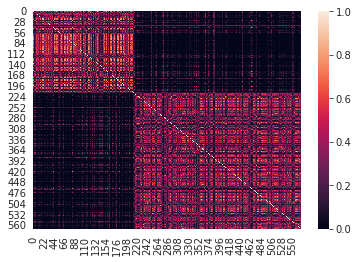

In [ ]:
import seaborn as sns

sns.heatmap(proximity_matrix[np.argsort(y), :][:,np.argsort(y)])

## MDS scaling and visualization

https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

In [ ]:
# in proximity matrix 1 means points are identical
# mds needs something which resembles metrix, so it needs matrix where identical points have value 0
dissimilarity_matrix = 1.0 - proximity_matrix
dissimilarity_matrix

array([[0.  , 0.25, 0.  , ..., 0.25, 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform( dissimilarity_matrix)

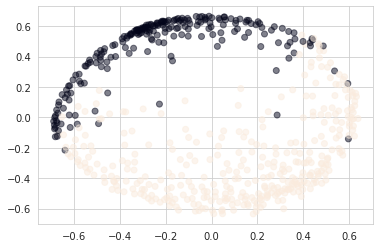

In [ ]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(1)

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y, alpha=0.5)
plt.show()

## Clustering 

https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


# setting distance_threshold=0 ensures we compute the full tree.
cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete')
cluster.fit(dissimilarity_matrix)

(cluster.labels_ == y).mean()

0.8822495606326889

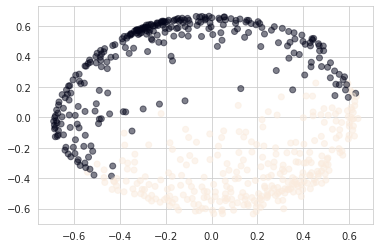

In [ ]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(1)

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=cluster.labels_, alpha=0.5)
plt.show()